In [1]:
from typing import List, Tuple
import copy
import numpy as np
import joblib
import time
import os
import math

from src.environment import *
from src.agents import *
from src.visualization import *

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
from IPython.display import Image as IPyImage
import seaborn as sns
%matplotlib inline

In [2]:
#prepare folder to save images
runtime_id = str(int(time.time() * 1000))
output_dir = f'output/run_{runtime_id}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    os.makedirs(output_dir+'/cliff_fall_heatmaps')
    os.makedirs(output_dir+'/learned_policy')

In [3]:
# #interface to try manually move agents
# env = CliffBoxGridWorld(render=True)
# env.reset()
# env.print_world()
# done = False
# rewards = []

# while not done:
#     action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
#     state, reward, done, info = env.step(action)
#     rewards.append(reward)
#     print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
#     env.print_world()

# print(f'rewards: {sum(rewards)}')
# print(f'action history: {env.action_history}')

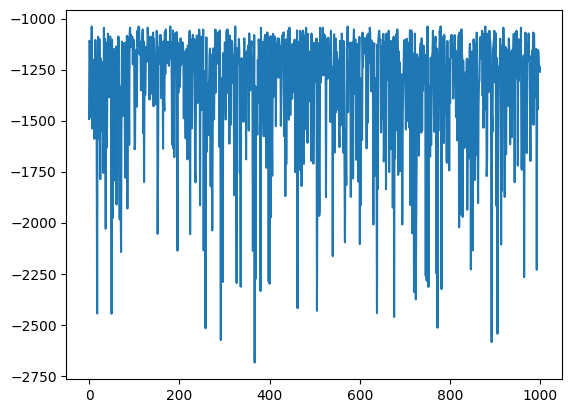

In [4]:
#example of training a random agent
env = CliffBoxGridWorld()
agent = RandomAgent(env, num_episodes=1000)
rewards = agent.learn()

# Plot the learning curve
plt.plot(rewards)

Success rate: 0.674


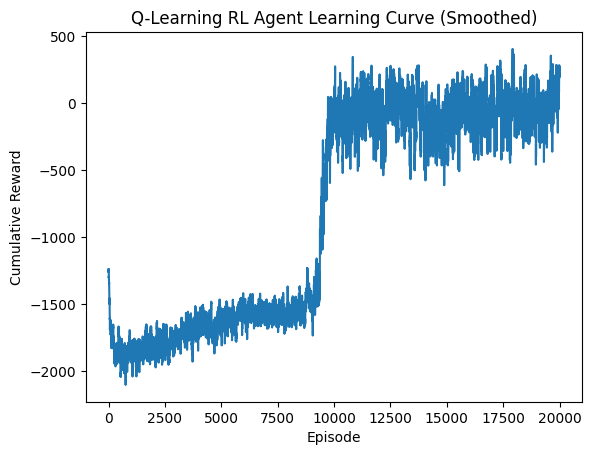

In [5]:
#train custom model
env = CliffBoxGridWorld()
n_episode = int(20000)
agent = RLAgent(env, num_episodes=n_episode)
rewards, cliff_fall_frac = agent.learn()

#save model
joblib.dump(agent, f"{output_dir}/rl_agent_n_episode_{n_episode}.pkl")

# Calculate success rate
final_rewards = np.array(rewards[-2000:])
success_rate = np.sum(final_rewards > 0) / len(final_rewards)
print(f"Success rate: {success_rate}")

# Smooth plot
weight=0.95
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# Plot the learning curve
plt.plot(smoothed)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Q-Learning RL Agent Learning Curve (Smoothed)')
plt.savefig(f'{output_dir}/learning_curve.png')

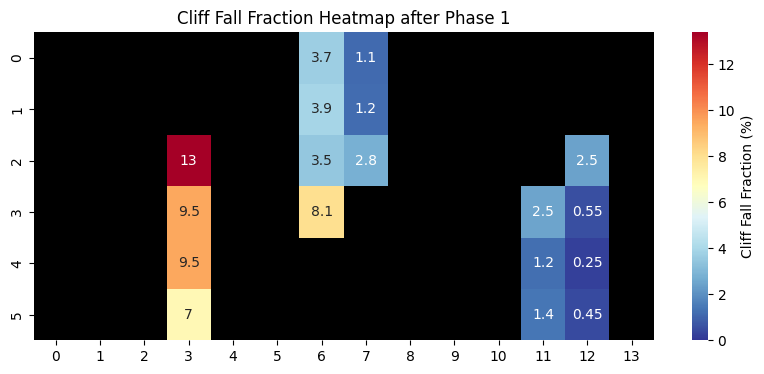

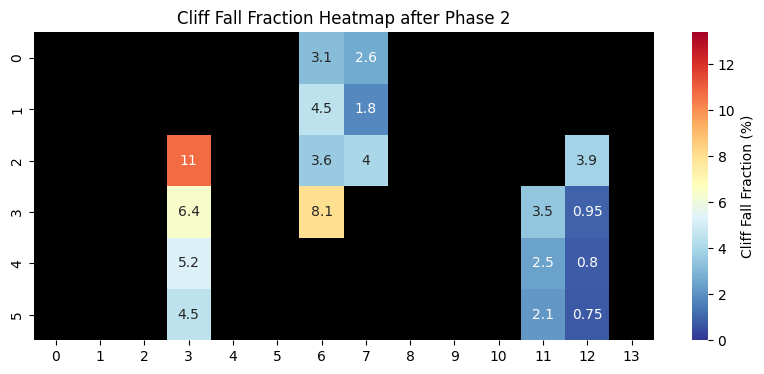

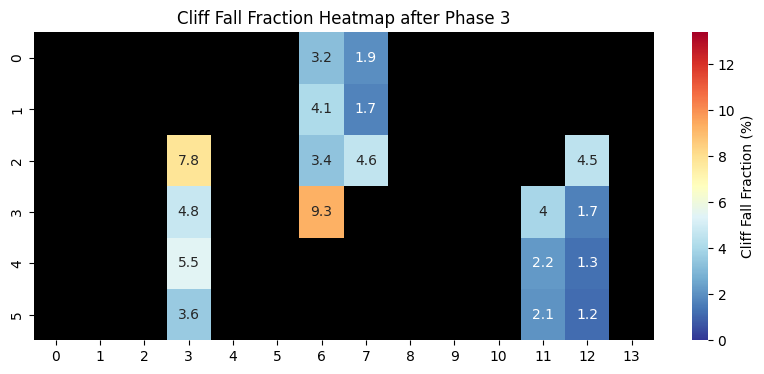

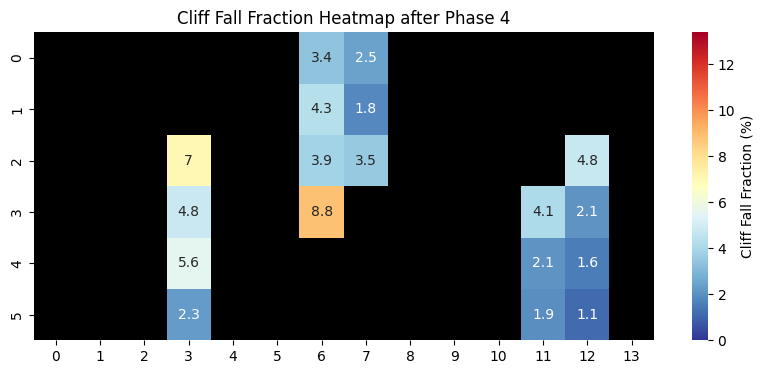

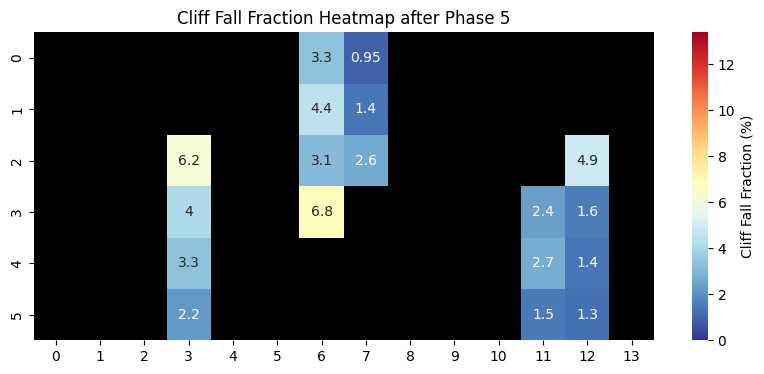

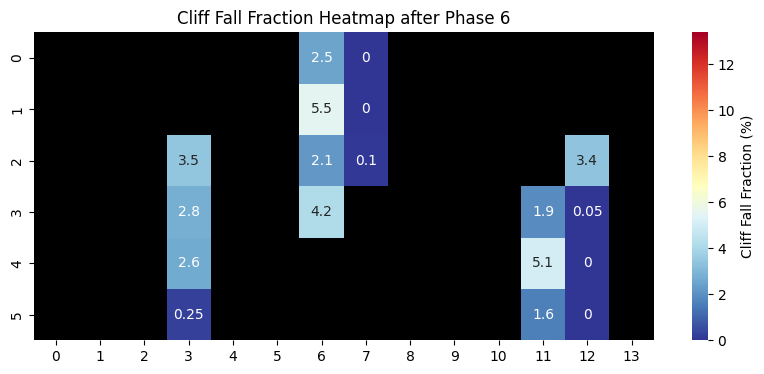

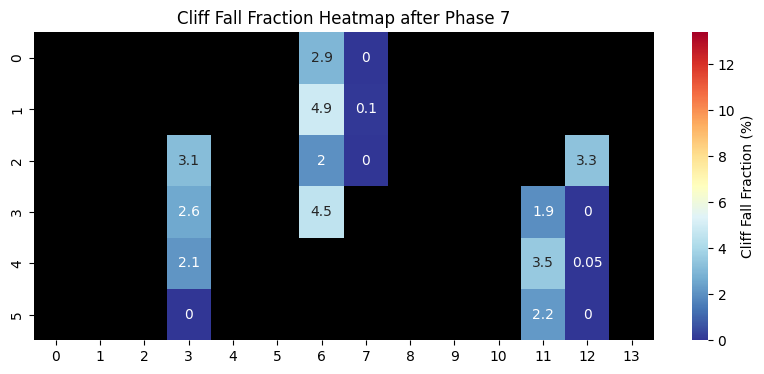

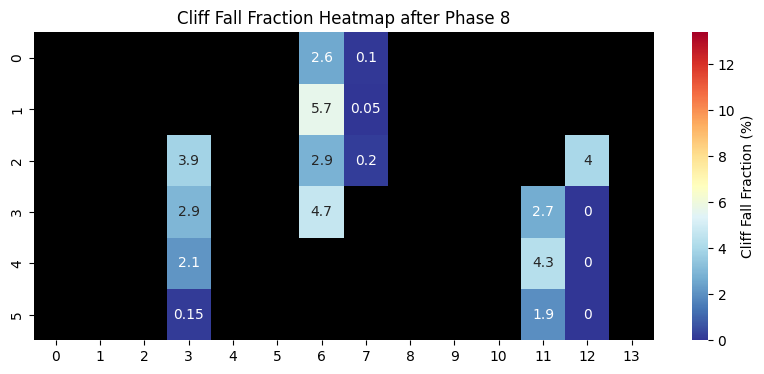

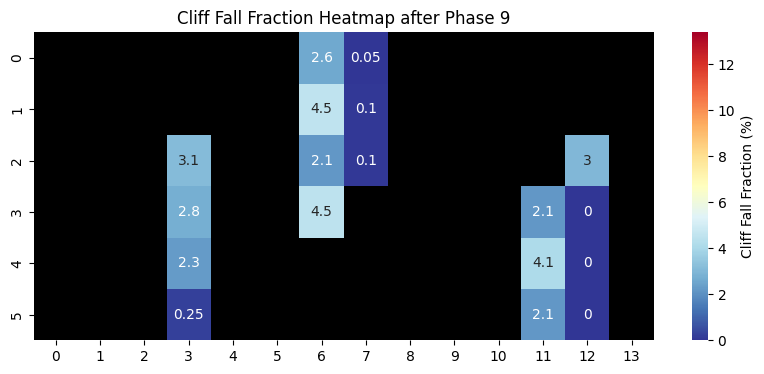

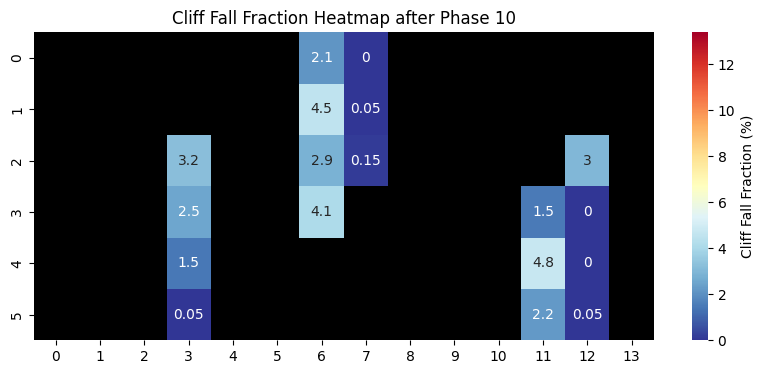

In [6]:
### ASSIGNMENT START

# Visualize cliff fall fraction heatmap
max_frac = max([max(cliff_fall_frac[i].values()) for i in range(len(cliff_fall_frac))]) * 100
for idx, frac_dict in enumerate(cliff_fall_frac):
    cliff_fall_frac_heatmap = np.zeros((env.world_height, env.world_width))*np.nan #initialize with nan for non-cliff cells
    for cell, frac in frac_dict.items():
        if env._check_off_cliff(cell):
            cliff_fall_frac_heatmap[cell] = frac * 100

    plt.figure(figsize=(10, 4))
    cmap = plt.cm.RdYlBu_r.copy()
    cmap.set_bad(color='black')  # Set color for NaN values
    sns.heatmap(cliff_fall_frac_heatmap, annot=True, vmin=0, vmax=max_frac, cmap=cmap, cbar_kws={'label': 'Cliff Fall Fraction (%)'})
    plt.title(f"Cliff Fall Fraction Heatmap after Phase {idx+1}")
    plt.savefig(f'{output_dir}/cliff_fall_heatmaps/heatmap_phase_{idx+1:03}.png', bbox_inches='tight')
    plt.show()

### ASSIGNMENT END

In [7]:
# #load agent
# agent = joblib.load(f'output/rl_agent_n_episode_{n_episode}.pkl')

In [8]:
#visualize training results
visualize(agent.q_table)

State space: 7056
v_table (2, 13, 3, 13) 0.14143990929705208
policy (2, 13, 3, 13) 2
v_table (1, 13, 2, 13) 0.1396003401360543
policy (1, 13, 2, 13) 2
v_table (1, 13, 3, 13) 0.1396003399292629
policy (1, 13, 3, 13) 2
v_table (0, 13, 1, 13) 0.1376374433106574
policy (0, 13, 1, 13) 2
v_table (1, 12, 2, 13) 0.1376374430320503
policy (1, 12, 2, 13) 4
v_table (0, 13, 2, 13) 0.13763743739735484
policy (0, 13, 2, 13) 2
v_table (0, 12, 1, 13) 0.13555245209750538
policy (0, 12, 1, 13) 4
v_table (1, 12, 1, 13) 0.13334658744047584
policy (1, 12, 1, 13) 1
v_table (0, 11, 1, 13) 0.13334658743641709
policy (0, 11, 1, 13) 4
v_table (1, 11, 1, 12) 0.13130450478602562
policy (1, 11, 1, 12) 4
v_table (1, 11, 1, 13) 0.13130450471440272
policy (1, 11, 1, 13) 4
v_table (1, 10, 1, 11) 0.1291411196021109
policy (1, 10, 1, 11) 4
v_table (0, 11, 1, 12) 0.12914111945566803
policy (0, 11, 1, 12) 2
v_table (2, 11, 1, 12) 0.12914111865932035
policy (2, 11, 1, 12) 1
v_table (1, 10, 1, 12) 0.12914111814477425
policy

In [9]:
#evaluate agent without exploration
env = CliffBoxGridWorld(render=True)
total_run = 1000
success = 0

for i in range(total_run):
    state = env.reset()
    done = False
    rewards = []
    
    while not done: 
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = env.step(action)
        state = next_state
        rewards.append(reward)
    if sum(rewards) > 0:
        success += 1
print(success/total_run)

1.0


In [10]:
#evaluate agent with exploration and visualization
env = CliffBoxGridWorld(render=True)
state = env.reset()
env.print_world()
done = False
rewards = []

while not done: # Run until game terminated
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    state = next_state
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
step: 1, state: (5, 1, 4, 1), actions: 4, reward: -14
Action: 4
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'_' b'A' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
step: 2, state: (4, 1, 3, 1), actions: 1, reward: -15
Acti

In [11]:
### ASSIGNMENT START

#add custom visualization of learned policy

#initialize environment
env = CliffBoxGridWorld(render=True)
state = env.reset()
done = False
rewards = []

#get the state matrix and convert to integers
world_state = np.char.decode(env.world, "utf-8")
unique_values = np.unique(world_state)
val_to_int = {val: idx for idx, val in enumerate(unique_values)}
cmap = ListedColormap(['lightblue', 'grey', 'green', 'white', 'red'])

plot_state_grid(
    world_state=world_state,
    val_to_int=val_to_int,
    cmap=cmap,
    title=f"Initial State",
    output_path=f'{output_dir}/learned_policy/step_000.png',
)

while not done: 
    #agent takes action based on learned policy
    action = agent.act(state, is_training=False)
    next_state, reward, done, info = env.step(action)
    state = next_state
    rewards.append(reward)
    world_state = np.char.decode(env.world, "utf-8")

    plot_state_grid(
        world_state=world_state,
        val_to_int=val_to_int,
        cmap=cmap,
        title=f'Step: {env.timesteps:03}, State: {state}, Actions: {action}, Reward: {reward}',
        output_path=f'{output_dir}/learned_policy/step_{env.timesteps:03}.png',
    )

#plot final state
world_state = np.char.decode(env.world, "utf-8")

plot_state_grid(
    world_state=world_state,
    val_to_int=val_to_int,
    cmap=cmap,
    title=f'Final State at Step: {env.timesteps:03}, Total Reward: {sum(rewards)}',
    output_path=f'{output_dir}/learned_policy/step_terminal.png',
)
### ASSIGNMENT END

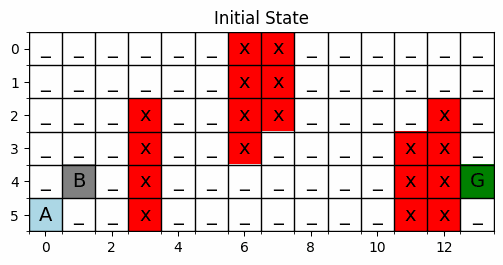

In [12]:
#save results as gif
image_files = sorted([os.path.join(output_dir+'/learned_policy', f) for f in os.listdir(output_dir+'/learned_policy') if f.endswith((".png"))])
images = [Image.open(f) for f in image_files]

gif_path = f"{output_dir}/learned_policy.gif"
images[0].save(
    gif_path,
    save_all=True,
    append_images=images[1:],
    duration=200,   # ms per frame
    loop=0
)
IPyImage(filename=gif_path)

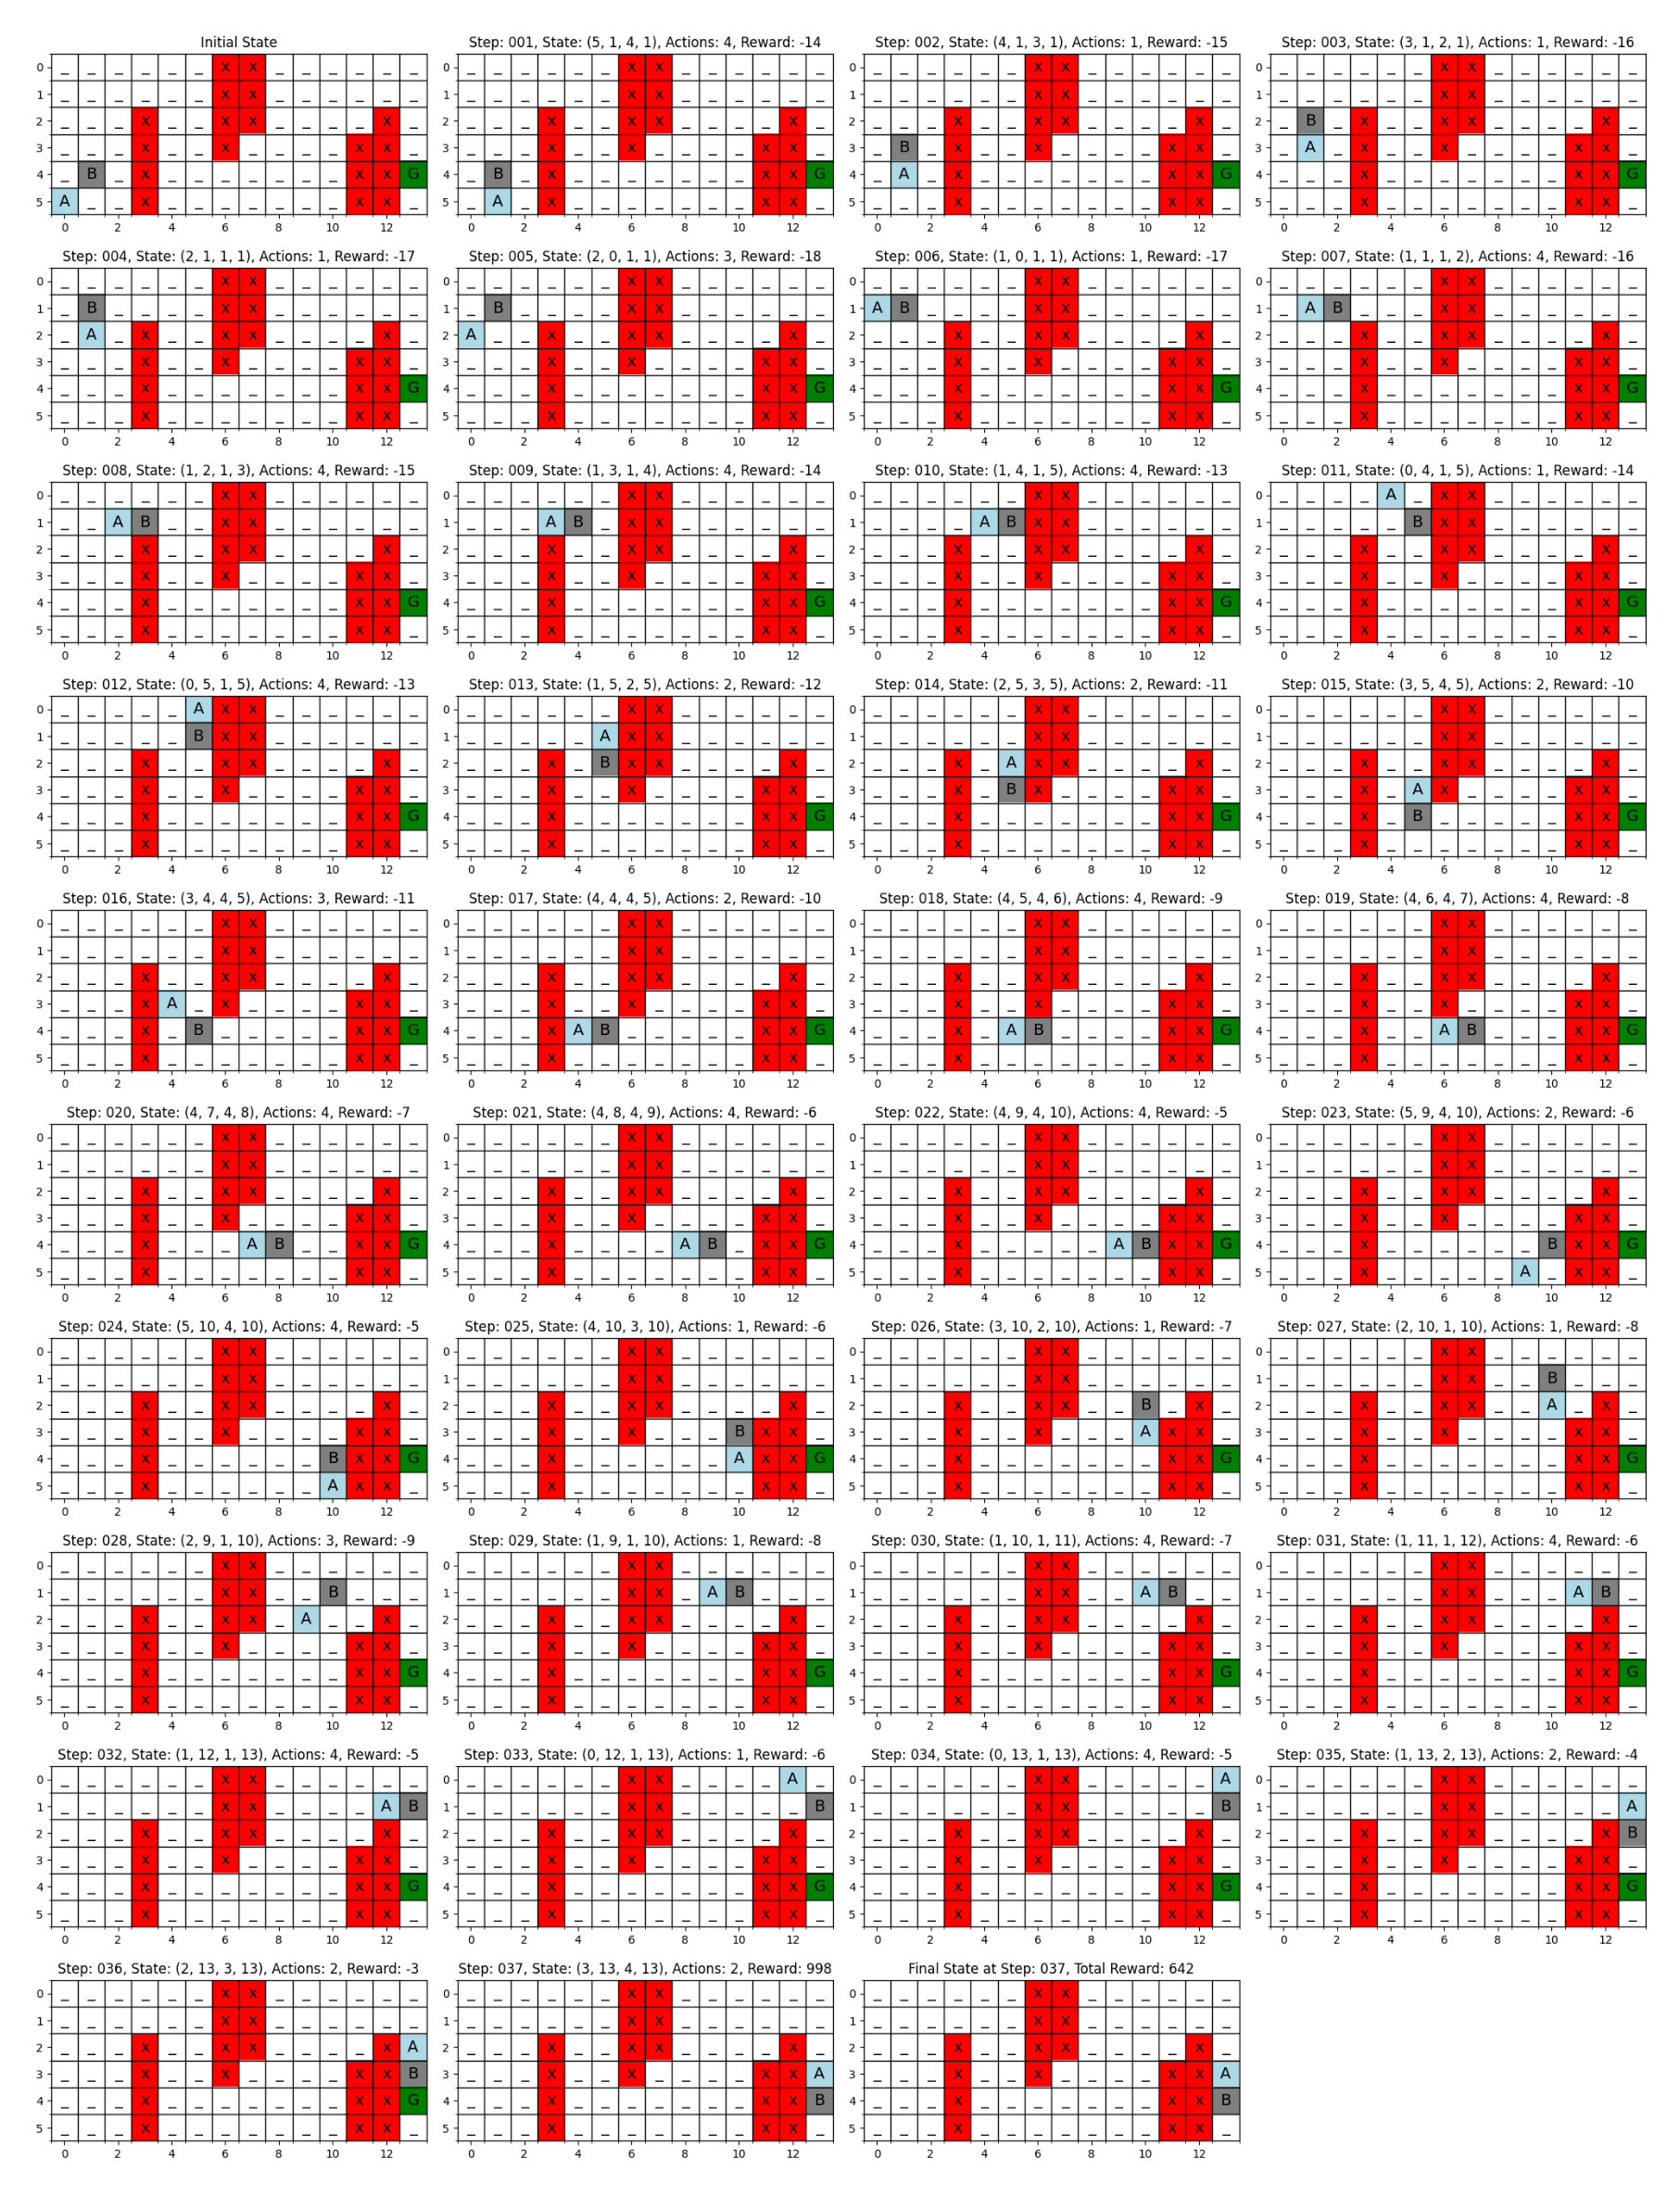

In [13]:
#save results as one big collage
n = len(images)
# rows = cols = math.ceil(math.sqrt(n))  # squa
rows = math.ceil(n / 4)
cols = 4

w, h = images[0].size
collage = Image.new("RGB", (cols * w, rows * h), color="white")

for idx, img in enumerate(images):
    r, c = divmod(idx, cols)
    collage.paste(img, (c * w, r * h))

# Show collage
plt.figure(figsize=(10, 10), dpi=300)
plt.imshow(collage)
plt.axis("off")
plt.savefig(f"{output_dir}/learned_policy_collage.png", bbox_inches="tight")
plt.show()